# Online Bayesian inference on MNIST using pre-sampled predictions
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from batchbald_redux import online_bayesian_inference

In [ ]:
!ls -hl mnist_model_10k.pt

-rw-rw-r-- 1 blackhc blackhc 3.8G Apr 19 16:04 mnist_model_10k.pt


In [ ]:
log_probs_N_M_C, labels_N = torch.load("mnist_model_10k.pt")

In [ ]:
log_probs_N_M_C.shape, labels_N.shape

(torch.Size([10100, 10000, 10]), torch.Size([10100]))

In [ ]:
import inspect

from IPython import display


def _display_source(code):
    def _jupyterlab_repr_html_(self):
        from pygments import highlight
        from pygments.formatters import HtmlFormatter

        fmt = HtmlFormatter()
        style = "<style>{}\n{}</style>".format(
            fmt.get_style_defs(".output_html"), fmt.get_style_defs(".jp-RenderedHTML")
        )
        return style + highlight(self.data, self._get_lexer(), fmt)

    # Replace _repr_html_ with our own version that adds the 'jp-RenderedHTML' class
    # in addition to 'output_html'.
    display.Code._repr_html_ = _jupyterlab_repr_html_
    return display.Code(data=code, language="python3")


def show_code(symbol):
    return _display_source(inspect.getsource(symbol))

The sampled predictions are made up of a the log probs of 10k different MC dropout samples for 100 training samples and 10000 MNIST samples. The model itself was trained on the first 25 samples.

So `log_probs_N_M_C[:25]` contains log probs for samples the model was trained on (and hence will be quite high)

## Performance of the model itself

We can compute the (sampled) accuracy and cross-entropy of the model itself as well as look at the best performing MC dropout samples.



In [ ]:
best_acc, best_ce_by_acc = online_bayesian_inference.eval_best_by_individual_accuracy(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, training_set_size=100
)

Best accuracy:  0.7324000000953674
Crossentropy:  1.0581727027893066


In [ ]:
best_acc_by_ce, best_ce = online_bayesian_inference.eval_best_by_individual_crossentropy(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, training_set_size=100
)

Accuracy:  0.7089999914169312
Best crossentropy:  0.9352366328239441


In [ ]:
# Overall (compute predictive distribution by averaging over samples)
bayesian_acc, bayesian_ce = online_bayesian_inference.eval_best_by_individual_accuracy(
    log_probs_N_M_C=torch.logsumexp(log_probs_N_M_C, dim=1, keepdim=True) - np.log(log_probs_N_M_C.shape[1]),
    labels_N=labels_N,
    training_set_size=100,
)

Best accuracy:  0.7167999744415283
Crossentropy:  0.8951576352119446


The Bayesian model has 72% acc with 0.89 nats CE.

The best individual accuracy is 73% with 1.05 nats CE.
The best individual CE is 0.93 with 71%.

Let's visualize all that:

In [ ]:
accuracy_M, crossentropy_M = online_bayesian_inference.get_accuracy_crossentropy(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, training_set_size=100
)

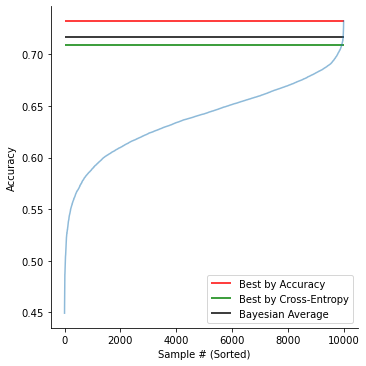

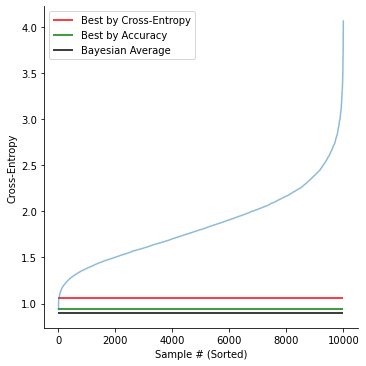

In [ ]:
g = sns.relplot(x=range(len(accuracy_M)), y=accuracy_M.sort().values, kind="line", alpha=0.5)
g.set_axis_labels("Sample # (Sorted)", "Accuracy")
g.ax.hlines(best_acc, xmin=0, xmax=10000, color="r", label="Best by Accuracy")
g.ax.hlines(best_acc_by_ce, xmin=0, xmax=10000, color="g", label="Best by Cross-Entropy")
g.ax.hlines(bayesian_acc, xmin=0, xmax=10000, color="black", label="Bayesian Average")
g.ax.legend(loc="lower right")

g = sns.relplot(x=range(len(crossentropy_M)), y=crossentropy_M.sort().values, kind="line", alpha=0.5)
g.set_axis_labels("Sample # (Sorted)", "Cross-Entropy")
g.ax.hlines(best_ce_by_acc, xmin=0, xmax=10000, color="r", label="Best by Cross-Entropy")
g.ax.hlines(best_ce, xmin=0, xmax=10000, color="g", label="Best by Accuracy")
g.ax.hlines(bayesian_ce, xmin=0, xmax=10000, color="black", label="Bayesian Average")
g.ax.legend(loc="upper left")

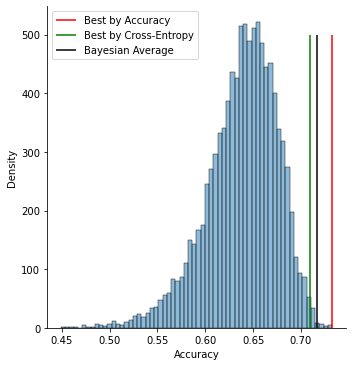

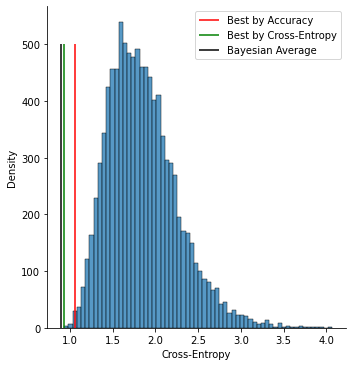

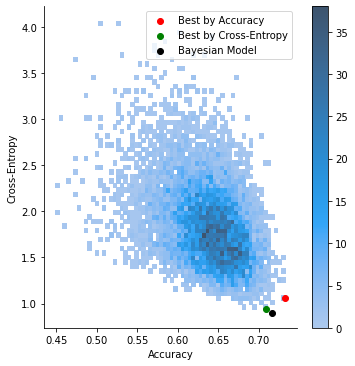

In [ ]:
g = sns.displot(x=accuracy_M, kind="hist", alpha=0.5)
g.set_axis_labels("Accuracy", "Density")
g.ax.vlines(best_acc, ymin=0, ymax=500, color="r", label="Best by Accuracy")
g.ax.vlines(best_acc_by_ce, ymin=0, ymax=500, color="g", label="Best by Cross-Entropy")
g.ax.vlines(bayesian_acc, ymin=0, ymax=500, color="black", label="Bayesian Average")
g.ax.legend()

g = sns.displot(x=crossentropy_M, kind="hist", fill=True)
g.set_axis_labels("Cross-Entropy", "Density")
g.ax.vlines(best_ce_by_acc, ymin=0, ymax=500, color="r", label="Best by Accuracy")
g.ax.vlines(best_ce, ymin=0, ymax=500, color="g", label="Best by Cross-Entropy")
g.ax.vlines(bayesian_ce, ymin=0, ymax=500, color="black", label="Bayesian Average")
g.ax.legend()

g = sns.displot(x=accuracy_M, y=crossentropy_M, kind="hist", cbar=True, stat="count")
g.set_axis_labels("Accuracy", "Cross-Entropy")
g.ax.scatter(best_acc, best_ce_by_acc, c="r", label="Best by Accuracy")
g.ax.scatter(best_acc_by_ce, best_ce, c="g", label="Best by Cross-Entropy")
g.ax.scatter(bayesian_acc, bayesian_ce, c="black", label="Bayesian Model")
g.ax.legend()

### No surprises in the implementation of these functions

In [ ]:
show_code(online_bayesian_inference.eval_best_by_individual_accuracy)

def eval_best_by_individual_accuracy(*, log_probs_N_M_C, labels_N, training_set_size):
    N, M, C = log_probs_N_M_C.shape

    predictions_n_M = torch.argmax(log_probs_N_M_C[training_set_size:], dim=2)
    accuracy_M = torch.mean((predictions_n_M == labels_N[training_set_size:, None]).float(), dim=0)
    best_accuracy, best_index = torch.max(accuracy_M, dim=0)

    crossentropy = -torch.mean(log_probs_N_M_C[list(range(training_set_size, N)), best_index,
                                               labels_N[training_set_size:]])

    best_accuracy = best_accuracy.cpu().item()
    crossentropy = crossentropy.cpu().item()

    print("Best accuracy: ", best_accuracy)
    print("Crossentropy: ", crossentropy)

    return best_accuracy, crossentropy

In [ ]:
show_code(online_bayesian_inference.eval_best_by_individual_crossentropy)

def eval_best_by_individual_crossentropy(*, log_probs_N_M_C, labels_N, training_set_size):
    N, M, C = log_probs_N_M_C.shape

    crossentropy_M = -torch.mean(log_probs_N_M_C[list(range(training_set_size, N)), :,
                                 labels_N[training_set_size:]], dim=0)
    best_crossentropy, best_index = torch.min(crossentropy_M, dim=0)
    predictions_n = torch.argmax(log_probs_N_M_C[training_set_size:, best_index, :], dim=1)
    accuracy = torch.mean((predictions_n == labels_N[training_set_size:]).float(), dim=0)

    accuracy = accuracy.cpu().item()
    best_crossentropy = best_crossentropy.cpu().item()
    print("Accuracy: ", accuracy)
    print("Best crossentropy: ", best_crossentropy)
    return accuracy, best_crossentropy

In [ ]:
show_code(online_bayesian_inference.get_accuracy_crossentropy)

def get_accuracy_crossentropy(*, log_probs_N_M_C, labels_N, training_set_size):
    N, M, C = log_probs_N_M_C.shape

    predictions_n_M = torch.argmax(log_probs_N_M_C[training_set_size:], dim=2)
    accuracy_M = torch.mean((predictions_n_M == labels_N[training_set_size:, None]).float(), dim=0)
    crossentropy_M = -torch.mean(log_probs_N_M_C[list(range(training_set_size, N)), :,
                                 labels_N[training_set_size:]], dim=0)
    return accuracy_M, crossentropy_M

## Different ensembles using the Test Set

### Bayesian Approach

Is the Bayesian model the best we can get though? What can we do if we condition on the whole test set (using online Bayesian inference)?

In essence, we create an ensemble (using the MC dropout samples) and weight each ensemble member using the unnormalized likelihoood on the test set itself.

In [ ]:
online_bayesian_inference.eval_best_bayesian(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, training_set_size=100, real_training_set_size=25
)

KL(best || ensemble) = tensor(-1.7148e-09, dtype=torch.float64)
OBIPerformance(total_training_set_size=10025, real_training_set_size=25, online_training_set_size=10000, trial_index=0, num_samples=10000, accuracy=0.7089999914169312, crossentropy=0.9352365679758881)


OBIPerformance(total_training_set_size=10025, real_training_set_size=25, online_training_set_size=10000, trial_index=0, num_samples=10000, accuracy=0.7089999914169312, crossentropy=0.9352365679758881)

The Bayesian approach picks exactly the MC dropout sample `eval_best_by_individual_crossentropy` and puts all its weight on it. And that's it.

This is not what I would have expected: it overfits to a sample even though it has less than optimal accuracy.

In [ ]:
test_log_likelihoods_M = online_bayesian_inference.get_log_likelihoods(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, start=100
)

In [ ]:
sorted_test_log_likelihoods_M = torch.sort(test_log_likelihoods_M).values

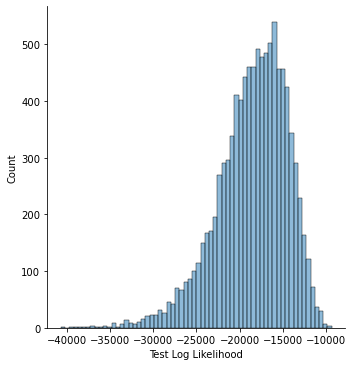

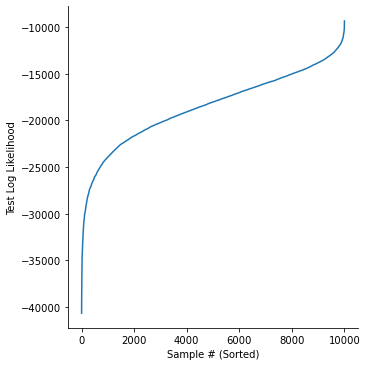

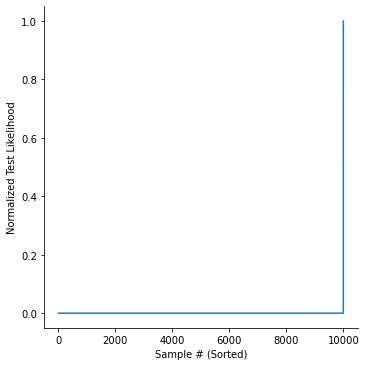

In [ ]:
sns.displot(sorted_test_log_likelihoods_M, kind="hist", stat="count", alpha=0.5).set_axis_labels("Test Log Likelihood")
sns.relplot(
    x=range(len(sorted_test_log_likelihoods_M)), y=(sorted_test_log_likelihoods_M), kind="line"
).set_axis_labels("Sample # (Sorted)", "Test Log Likelihood")
sns.relplot(
    x=range(len(sorted_test_log_likelihoods_M)),
    y=(sorted_test_log_likelihoods_M - sorted_test_log_likelihoods_M.logsumexp(dim=0)).exp(),
    kind="line",
).set_axis_labels("Sample # (Sorted)", "Normalized Test Likelihood")

While the histogram looks like there is a lot of variety etc. **If we plot the actual likelihood on the test set (and not the log likelihood), we see that it is just a Dirac probability!**

This also explains the bad behavior of OBI (online Bayesian inference) on more more limited training data. 

**This reminds me a lot of what I've read in https://arxiv.org/abs/1912.08335 "Learning under Model Misspecification", but I do not yet know how to apply that.**

## Other ways of ensembling the predictions

Instead of using Bayesian averaging (using the test likelihoods), we can also simple ensemble the top 10 best performing samples. And we have:

In [ ]:
online_bayesian_inference.eval_best_topk_liklihood_ensemble(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=100,
    real_training_set_size=25,
    k=10,
)

OBIPerformance(total_training_set_size=10025, real_training_set_size=25, online_training_set_size=10000, trial_index=0, num_samples=10000, accuracy=0.7508999705314636, crossentropy=0.7830026149749756)


OBIPerformance(total_training_set_size=10025, real_training_set_size=25, online_training_set_size=10000, trial_index=0, num_samples=10000, accuracy=0.7508999705314636, crossentropy=0.7830026149749756)

We obtain **75% accuracy and 0.78 nats CE**! This is better than all other results so far! Let's plot this.

In [ ]:
top10_ensemble = _

In [ ]:
top10_test_lls = torch.topk(test_log_likelihoods_M, k=10).indices

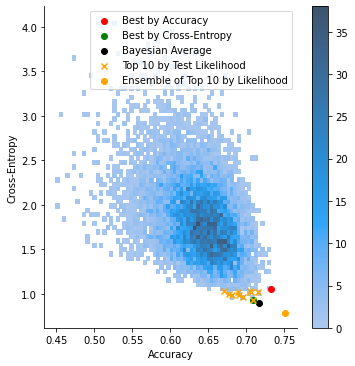

In [ ]:
g = sns.displot(x=accuracy_M, y=crossentropy_M, kind="hist", cbar=True, stat="count")
g.set_axis_labels("Accuracy", "Cross-Entropy")
g.ax.scatter(best_acc, best_ce_by_acc, c="r", label="Best by Accuracy")
g.ax.scatter(best_acc_by_ce, best_ce, c="g", label="Best by Cross-Entropy")
g.ax.scatter(bayesian_acc, bayesian_ce, c="black", label="Bayesian Model")
g.ax.scatter(
    accuracy_M[top10_test_lls],
    crossentropy_M[top10_test_lls],
    c="orange",
    marker="x",
    label="Top 10 by Test Likelihood",
)
g.ax.scatter(
    top10_ensemble.accuracy,
    top10_ensemble.crossentropy,
    c="orange",
    marker="o",
    label="Ensemble of Top 10 by Likelihood",
)
g.ax.legend()

## Examining Training Likelihoods

Do we have the same dynamic when we perform OBI on additional training data?

In [ ]:
obi_log_likelihoods = [
    online_bayesian_inference.get_log_likelihoods(log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, start=25, end=end)
    for end in range(25, 51)
]

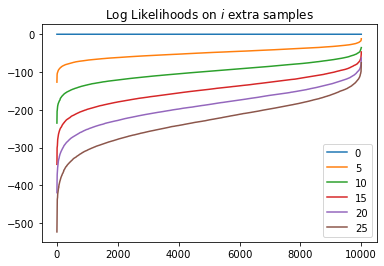

In [ ]:
for i, obi_log_likelihoods_i in zip(range(0, 26, 5), obi_log_likelihoods[::5]):
    sorted_log_likelihoods = torch.sort(obi_log_likelihoods_i).values
    sns.lineplot(x=range(len(sorted_log_likelihoods)), y=(sorted_log_likelihoods), label=i)

plt.title("Log Likelihoods on $i$ extra samples");

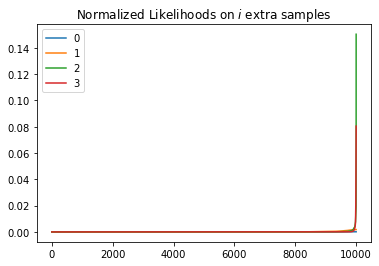

In [ ]:
for i, obi_log_likelihoods_i in zip(range(0, 4, 1), obi_log_likelihoods[:4:]):
    sorted_log_likelihoods = torch.sort(obi_log_likelihoods_i).values
    sns.lineplot(
        x=range(len(sorted_log_likelihoods)),
        y=(sorted_log_likelihoods - sorted_log_likelihoods.logsumexp(dim=0)).exp(),
        label=i,
    )

plt.title("Normalized Likelihoods on $i$ extra samples");

Here, we also see that other MC samples but the best one quickly drop towards 0. However, the total "mass" on them is >86% (the best MC dropout sample gets assigned ~15% in the ensemble for i=2).

What does this top mass assignment look like in general?

[9.99999901978299e-05, 0.001783629646524787, 0.15032584965229034, 0.08045611530542374, 0.1529366821050644, 0.673657238483429, 0.9321025013923645, 0.9316279292106628, 0.8989933729171753, 0.2907436192035675, 0.2376449853181839, 0.40481871366500854, 0.7447317838668823, 0.7847622632980347, 0.8904911875724792, 0.9034488201141357, 0.9526063799858093, 0.9753865599632263, 0.7988098859786987, 0.9018373489379883, 0.957996129989624, 0.9304186105728149, 0.7481658458709717, 0.6606672406196594, 0.7713676691055298, 0.6462547183036804]


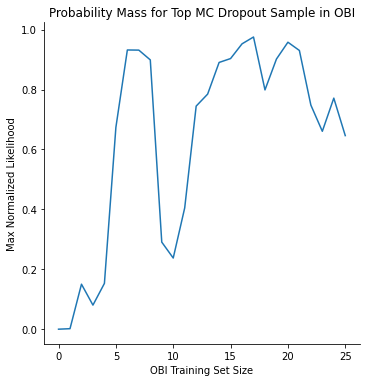

In [ ]:
obi_max_prob_masses = []
for obi_log_likelihoods_i in obi_log_likelihoods:
    max_mass = (obi_log_likelihoods_i.max() - obi_log_likelihoods_i.logsumexp(dim=0)).exp().cpu().item()
    obi_max_prob_masses += [max_mass]

print(obi_max_prob_masses)
g = sns.relplot(x=list(range(len(obi_max_prob_masses))), y=obi_max_prob_masses, kind="line")
g.set_axis_labels("OBI Training Set Size", "Max Normalized Likelihood")
plt.title("Probability Mass for Top MC Dropout Sample in OBI");

What does OBI's performance look like overall?

In [ ]:
obi_results = online_bayesian_inference.eval_obi_simple(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=100,
    start_index=25,
    end_index_start=25,
    end_index_end=50,
    num_samples_list=(10000,),
    num_trials=1,
    real_training_set_size=25,
)

Online Training Size/Num Samples/Trial: 25/10000/0
KL(best || ensemble) = 0.38786259293556213
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=25, trial_index=0, num_samples=10000, accuracy=0.7167999744415283, crossentropy=0.895157516002655, kl_best_marginal=0.38786259293556213)
Online Training Size/Num Samples/Trial: 26/10000/0
KL(best || ensemble) = 0.3971779942512512
OBIPerformance(total_training_set_size=26, real_training_set_size=25, online_training_set_size=26, trial_index=0, num_samples=10000, accuracy=0.6988999843597412, crossentropy=0.9597615003585815, kl_best_marginal=0.3971779942512512)
Online Training Size/Num Samples/Trial: 27/10000/0
KL(best || ensemble) = 0.2724074125289917
OBIPerformance(total_training_set_size=27, real_training_set_size=25, online_training_set_size=27, trial_index=0, num_samples=10000, accuracy=0.6891000270843506, crossentropy=0.989033579826355, kl_best_marginal=0.2724074125289917)
Online Training Size/Num 

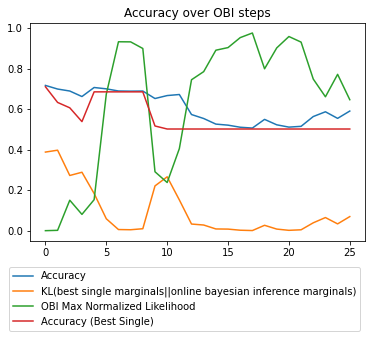

In [ ]:
plt.plot([result.accuracy for result in obi_results], label="Accuracy")
plt.plot(
    [result.kl_best_marginal for result in obi_results],
    label="KL(best single marginals||online bayesian inference marginals)",
)
plt.plot(obi_max_prob_masses, label="OBI Max Normalized Likelihood")

best_indices = np.array([ll.argmax() for ll in obi_log_likelihoods])

plt.plot(accuracy_M[best_indices], label="Accuracy (Best Single)")

plt.legend(bbox_to_anchor=(1, -0.1))
plt.title("Accuracy over OBI steps");

KL and Max Normalized Likelihood are closely coupled.

Moreover, the best single model stays the same for most of the OBI steps:

In [ ]:
print(best_indices)

[   0 8538 6993 4011 8400 8400 8400 8400 8400 5505 3865 3865 3865 3865
 3865 3865 3865 3865 3865 3865 3865 3865 3865 3865 3865 3865]


It seems that the best MC dropout sample in OBI mostly provides a lower-bound for the accuracy. An ensemble of multiple MC dropout samples always performs better.

The same holds for the cross-entropy:

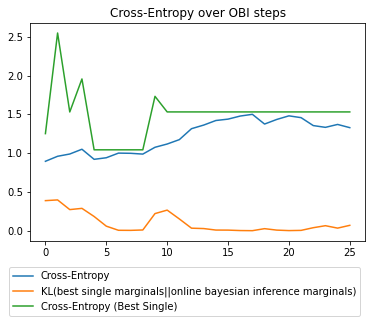

In [ ]:
plt.title("Cross-Entropy over OBI steps")
plt.plot([result.crossentropy for result in obi_results], label="Cross-Entropy")
plt.plot(
    [result.kl_best_marginal for result in obi_results],
    label="KL(best single marginals||online bayesian inference marginals)",
)

best_indices = np.array([ll.argmax() for ll in obi_log_likelihoods])

plt.plot(crossentropy_M[best_indices], label="Cross-Entropy (Best Single)")

plt.legend(bbox_to_anchor=(1, -0.1))

Where are the Top 10 MC dropout samples located for different OBI steps?

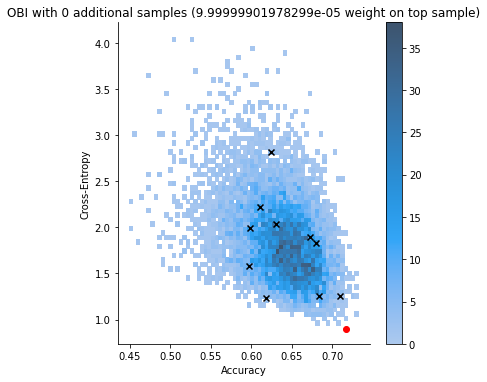

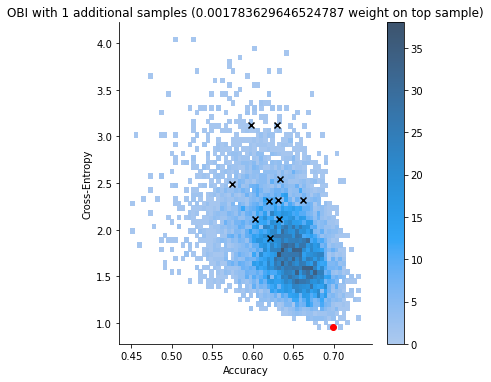

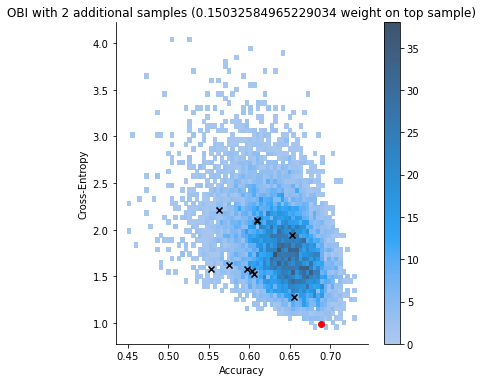

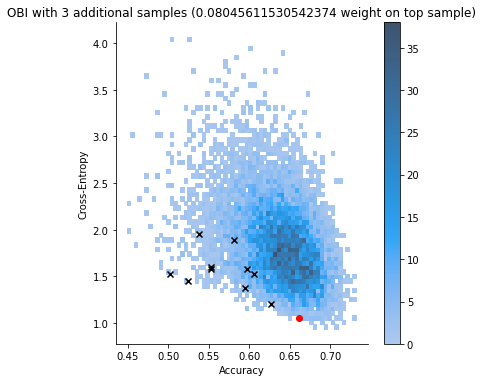

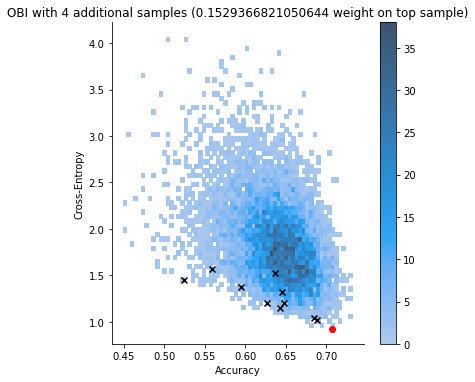

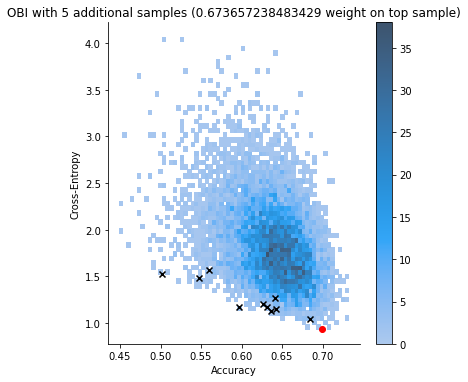

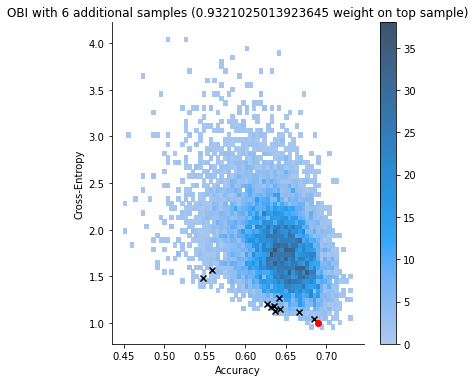

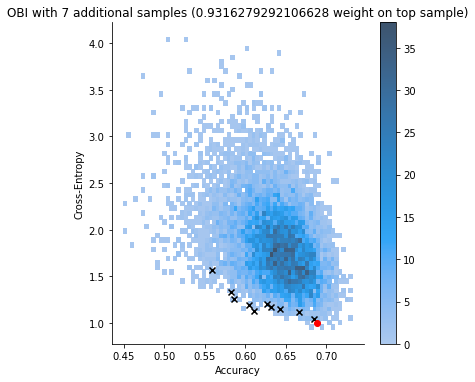

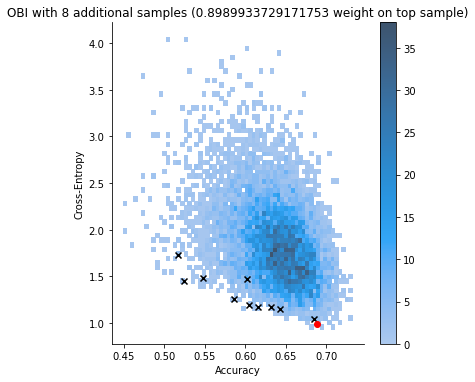

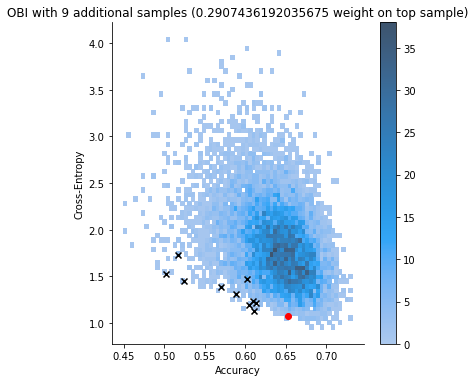

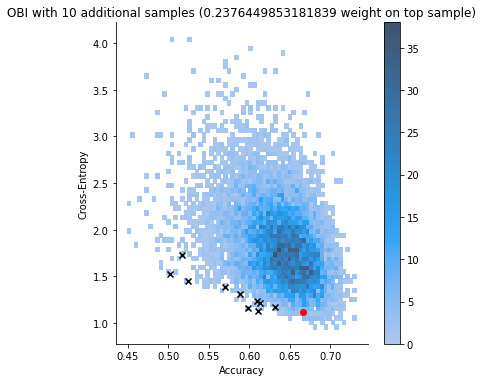

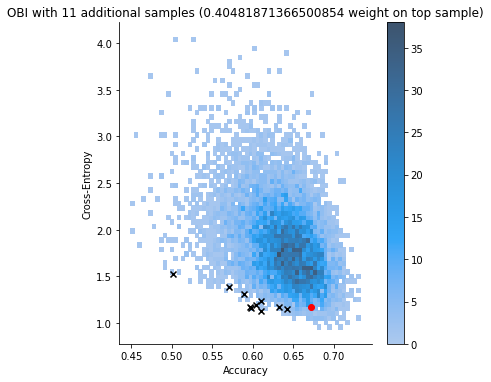

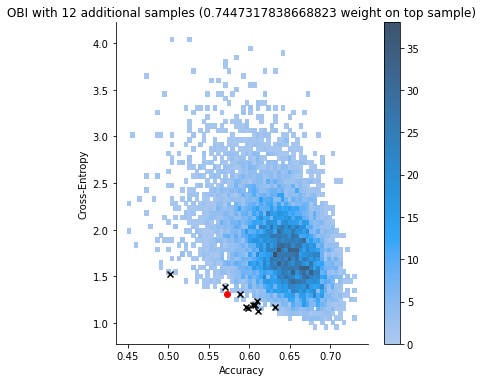

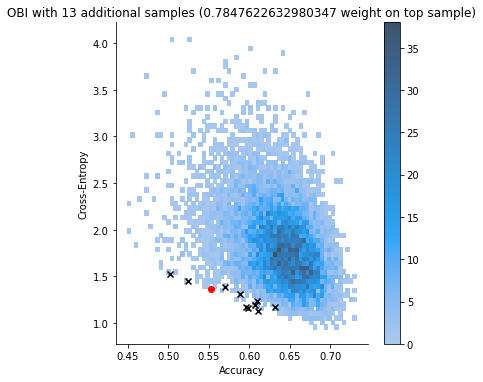

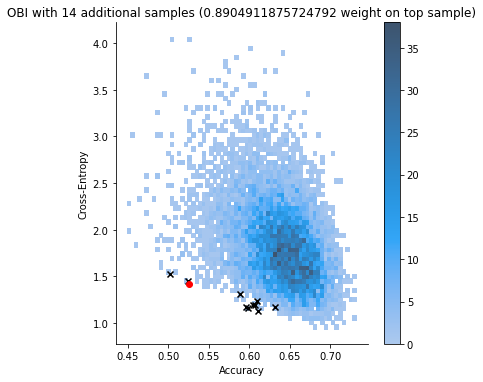

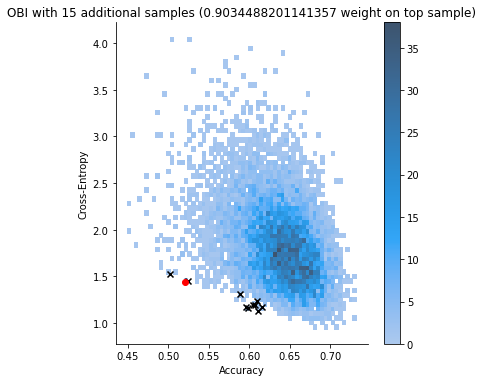

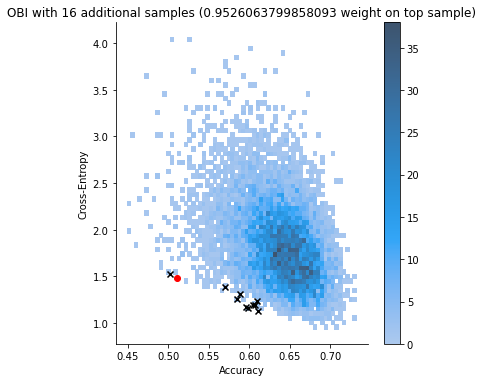

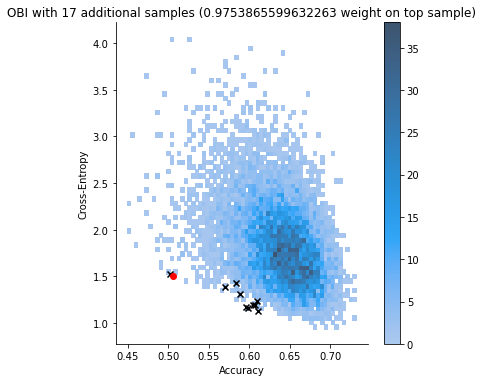

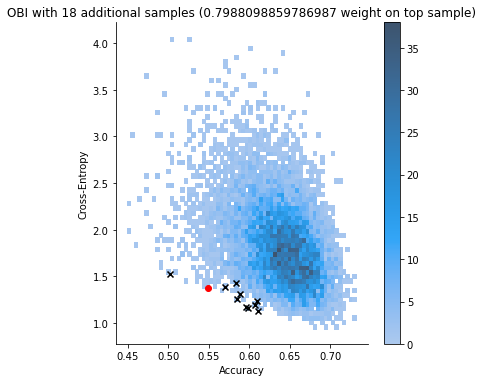

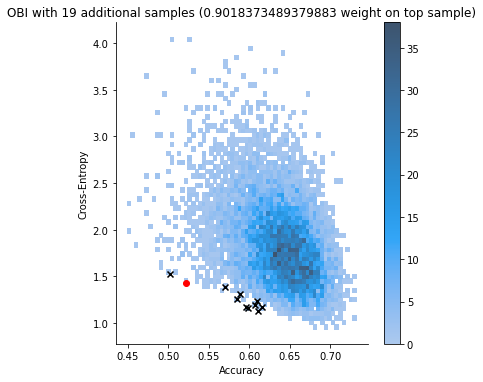

In [ ]:
for i, (log_likelihoods, obi_result) in enumerate(zip(obi_log_likelihoods[:20], obi_results)):
    g = sns.displot(x=accuracy_M, y=crossentropy_M, kind="hist", cbar=True, stat="count")
    g.set_axis_labels("Accuracy", "Cross-Entropy")

    top10_index = log_likelihoods.topk(k=10).indices
    g.ax.scatter(accuracy_M[top10_index], crossentropy_M[top10_index], marker="x", c="black", label="Top 10 Single")
    g.ax.scatter(obi_result.accuracy, obi_result.crossentropy, marker="o", c="red", label="Online Bayesian Inference")

    g.ax.set_title(f"OBI with {i} additional samples ({obi_max_prob_masses[i]} weight on top sample)")

## TopK Ensemble (instead of principled OBI)

Now what happens if we simply ensemble the top 10 MC dropout samples (using the OBI likelihood) by averaging. This performed better when conditioning on the whole test set.

In [ ]:
obi_topk_ensemble_results = online_bayesian_inference.eval_obi_simple_topk_ensemble(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=100,
    start_index=25,
    end_index_start=25,
    end_index_end=50,
    num_samples_list=(10000,),
    num_trials=1,
    real_training_set_size=25,
    k=10,
)

Online Training Size/Num Samples/Trial: 0/10000/0
KL(best || ensemble) = 0.35945677757263184
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=0, trial_index=0, num_samples=10000, accuracy=0.7024000287055969, crossentropy=0.9669974446296692, kl_best_marginal=0.35945677757263184)
Online Training Size/Num Samples/Trial: 1/10000/0
KL(best || ensemble) = 0.3003181517124176
OBIPerformance(total_training_set_size=26, real_training_set_size=25, online_training_set_size=1, trial_index=0, num_samples=10000, accuracy=0.6679999828338623, crossentropy=1.3629424571990967, kl_best_marginal=0.3003181517124176)
Online Training Size/Num Samples/Trial: 2/10000/0
KL(best || ensemble) = 0.3570598065853119
OBIPerformance(total_training_set_size=27, real_training_set_size=25, online_training_set_size=2, trial_index=0, num_samples=10000, accuracy=0.6636999845504761, crossentropy=1.1358036994934082, kl_best_marginal=0.3570598065853119)
Online Training Size/Num Samp

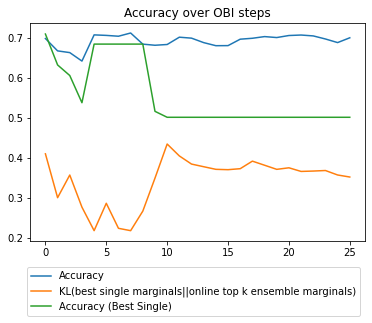

In [ ]:
plt.plot([result.accuracy for result in obi_topk_ensemble_results], label="Accuracy")
plt.plot(
    [result.kl_best_marginal for result in obi_topk_ensemble_results],
    label="KL(best single marginals||online top k ensemble marginals)",
)

best_indices = np.array([ll.argmax() for ll in obi_log_likelihoods])

plt.plot(accuracy_M[best_indices], label="Accuracy (Best Single)")

plt.legend(bbox_to_anchor=(1, -0.1))
plt.title("Accuracy over OBI steps");

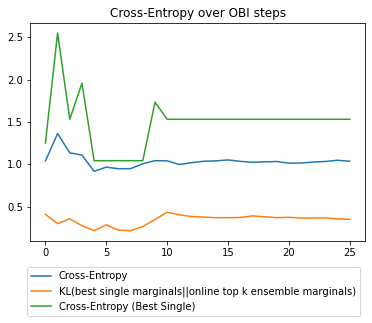

In [ ]:
plt.title("Cross-Entropy over OBI steps")
plt.plot([result.crossentropy for result in obi_topk_ensemble_results], label="Cross-Entropy")
plt.plot(
    [result.kl_best_marginal for result in obi_topk_ensemble_results],
    label="KL(best single marginals||online top k ensemble marginals)",
)

best_indices = np.array([ll.argmax() for ll in obi_log_likelihoods])

plt.plot(crossentropy_M[best_indices], label="Cross-Entropy (Best Single)")

plt.legend(bbox_to_anchor=(1, -0.1))

This looks much better with a larger gap and higher/more stable performance overall. However, the reweighted model (using additional training data) does not seem to outperform the original model.

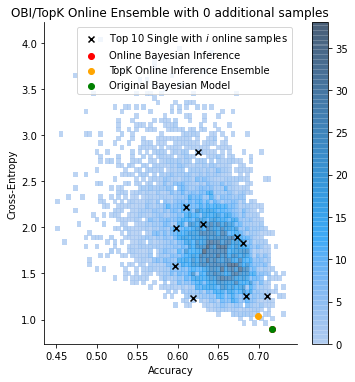

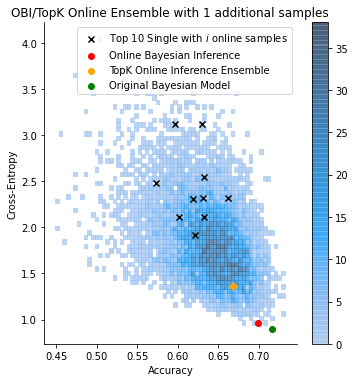

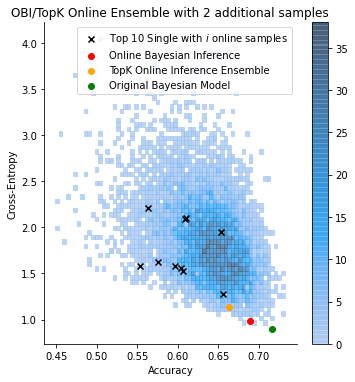

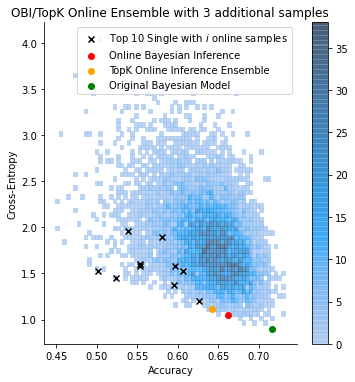

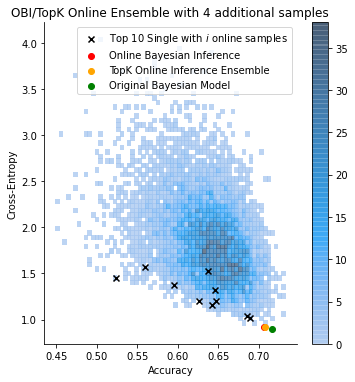

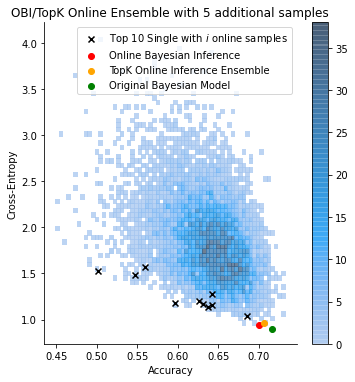

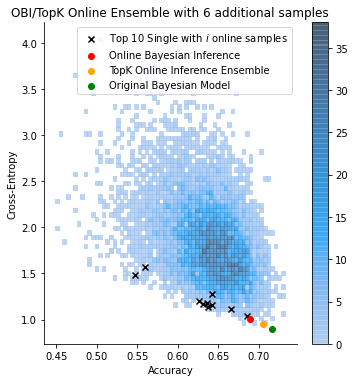

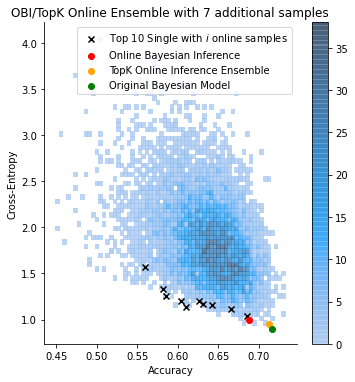

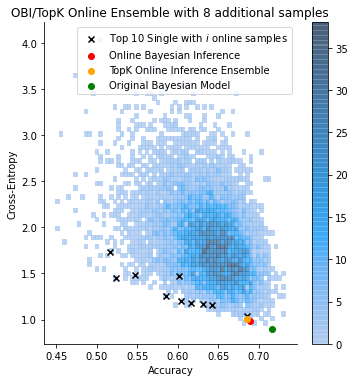

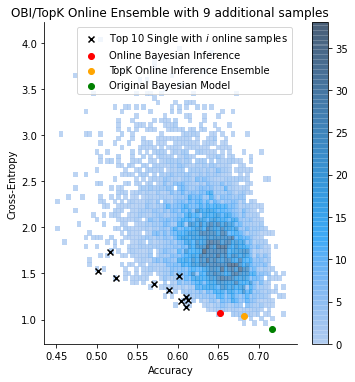

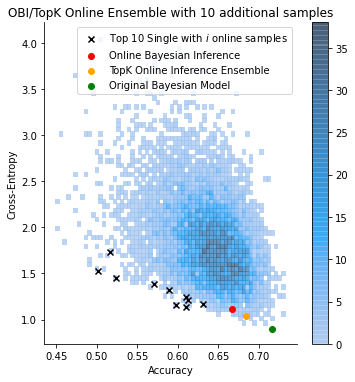

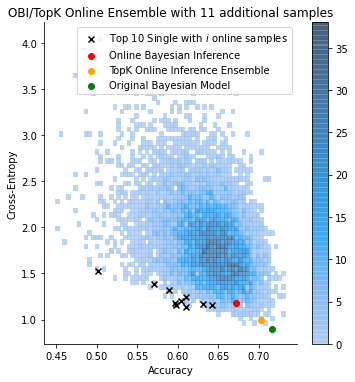

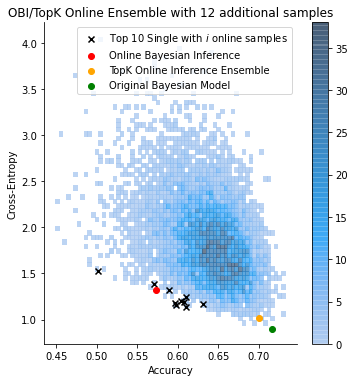

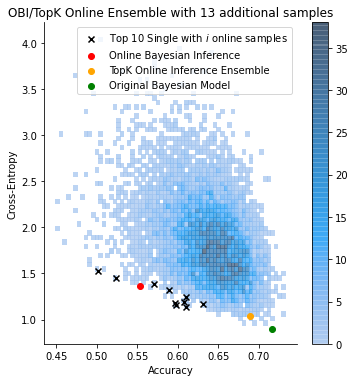

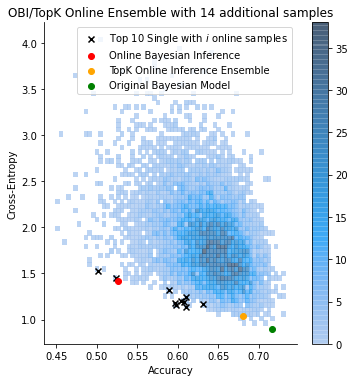

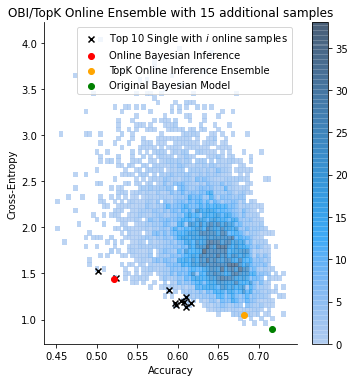

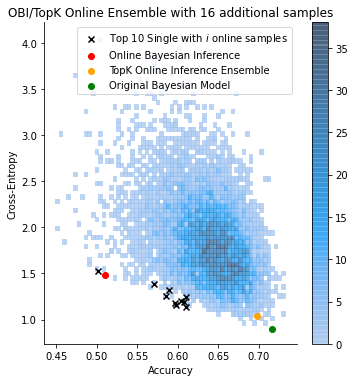

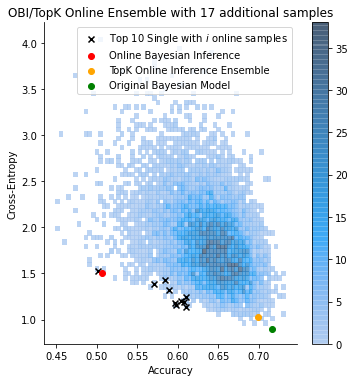

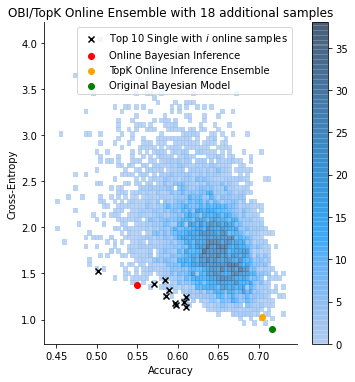

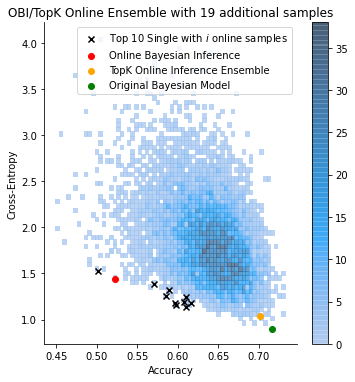

In [ ]:
for i, (log_likelihoods, obi_result, obi_topk_result) in enumerate(
    zip(obi_log_likelihoods[:20], obi_results, obi_topk_ensemble_results)
):
    g = sns.displot(x=accuracy_M, y=crossentropy_M, kind="hist", cbar=True, stat="count", alpha=0.75)
    g.set_axis_labels("Accuracy", "Cross-Entropy")

    top10_index = log_likelihoods.topk(k=10).indices
    g.ax.scatter(
        accuracy_M[top10_index],
        crossentropy_M[top10_index],
        marker="x",
        c="black",
        label=f"Top 10 Single with $i$ online samples",
    )
    g.ax.scatter(obi_result.accuracy, obi_result.crossentropy, marker="o", c="red", label="Online Bayesian Inference")
    g.ax.scatter(
        obi_topk_result.accuracy,
        obi_topk_result.crossentropy,
        marker="o",
        c="orange",
        label="TopK Online Inference Ensemble",
    )
    g.ax.scatter(bayesian_acc, bayesian_ce, marker="o", c="green", label="Original Bayesian Model")

    g.ax.set_title(f"OBI/TopK Online Ensemble with {i} additional samples")
    g.ax.legend()

## Examining the Correlation between the Additional Training Data and the Test Performance

In [ ]:
training_likelihood_M = online_bayesian_inference.get_log_likelihoods(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, start=0, end=25
)

In [ ]:
obi_likelihood_M = online_bayesian_inference.get_log_likelihoods(
    log_probs_N_M_C=log_probs_N_M_C, labels_N=labels_N, start=25, end=100
)

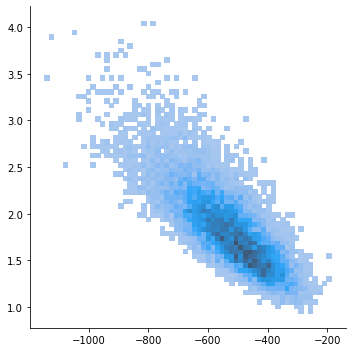

In [ ]:
sns.displot(x=obi_likelihood_M - training_likelihood_M, y=crossentropy_M)

In [ ]:
obi_ce_M = -obi_likelihood_M / 75

In [ ]:
best_by_acc = accuracy_M.argmax()
best_by_ce = crossentropy_M.argmin()

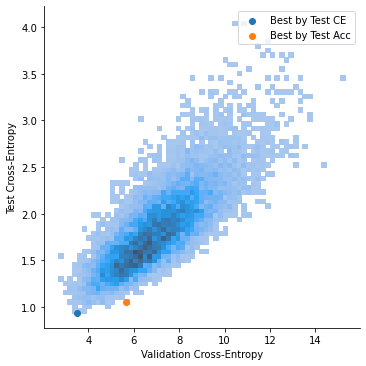

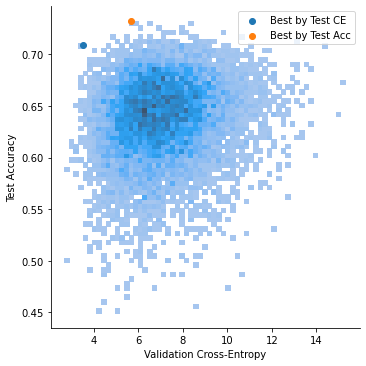

In [ ]:
g = sns.displot(x=obi_ce_M, y=crossentropy_M)
g.set_axis_labels("Validation Cross-Entropy", "Test Cross-Entropy")
g.ax.scatter(x=obi_ce_M[best_by_ce], y=crossentropy_M[best_by_ce], label="Best by Test CE")
g.ax.scatter(x=obi_ce_M[best_by_acc], y=crossentropy_M[best_by_acc], label="Best by Test Acc")
plt.legend()
plt.show()

g = sns.displot(x=obi_ce_M, y=accuracy_M)
g.set_axis_labels("Validation Cross-Entropy", "Test Accuracy")
g.ax.scatter(x=obi_ce_M[best_by_ce], y=accuracy_M[best_by_ce], label="Best by Test CE")
g.ax.scatter(x=obi_ce_M[best_by_acc], y=accuracy_M[best_by_acc], label="Best by Test Acc")
plt.legend()
plt.show()

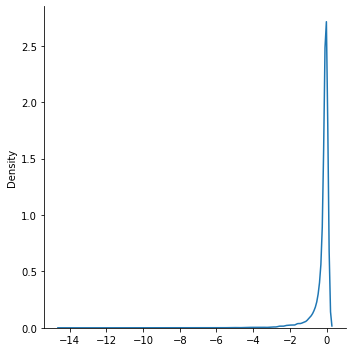

In [ ]:
sns.displot(training_likelihood_M, kind="kde")

## Convex Optimization of the Ensemble Weights

In [ ]:
obi_results = online_bayesian_inference.eval_obi_simple(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=100,
    start_index=25,
    end_index_start=25,
    end_index_end=25,
    num_samples_list=(10000,),
    num_trials=1,
    real_training_set_size=25,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10000/0
KL(best || ensemble) = 0.6306161284446716
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=0, trial_index=0, num_samples=10000, accuracy=0.7167999744415283, crossentropy=0.895157516002655, kl_best_marginal=0.6306161284446716)


In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=100,
    num_samples_list=[10000],
    num_trials=1,
    real_training_set_size=25,
    start_index=25,
    end_index_start=100,
    end_index_end=100,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 75/10000/0


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 2.1754143238067627
KL(best || ensemble) = 0.49033311009407043
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=0, num_samples=10000, accuracy=0.7217000126838684, crossentropy=0.9416889548301697, kl_best_marginal=0.49033311009407043)


[OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=0, num_samples=10000, accuracy=0.7217000126838684, crossentropy=0.9416889548301697, kl_best_marginal=0.49033311009407043)]

### 75 Test Samples

In [ ]:
obi_results = online_bayesian_inference.eval_obi_simple(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=175,
    start_index=25,
    end_index_start=25,
    end_index_end=25,
    num_samples_list=(10000,),
    num_trials=1,
    real_training_set_size=25,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10000/0
KL(best || ensemble) = 0.5256817936897278
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=0, trial_index=0, num_samples=10000, accuracy=0.7163727879524231, crossentropy=0.896579921245575, kl_best_marginal=0.5256817936897278)


In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=175,
    num_samples_list=[10000],
    num_trials=1,
    real_training_set_size=25,
    start_index=100,
    end_index_start=175,
    end_index_end=175,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 75/10000/0


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.3741679787635803
KL(best || ensemble) = 0.257214218378067
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=0, num_samples=10000, accuracy=0.7277581691741943, crossentropy=1.0136305093765259, kl_best_marginal=0.257214218378067)


[OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=0, num_samples=10000, accuracy=0.7277581691741943, crossentropy=1.0136305093765259, kl_best_marginal=0.257214218378067)]

In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=175,
    num_samples_list=[100],
    num_trials=5,
    real_training_set_size=25,
    start_index=100,
    end_index_start=175,
    end_index_end=175,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 75/100/0


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.5331661701202393
KL(best || ensemble) = 0.2195492833852768
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=0, num_samples=100, accuracy=0.7303778529167175, crossentropy=0.8514002561569214, kl_best_marginal=0.2195492833852768)
Online Training Size/Num Samples/Trial: 75/100/1


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.5409621000289917
KL(best || ensemble) = 0.22694572806358337
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=1, num_samples=100, accuracy=0.7235264778137207, crossentropy=1.0051196813583374, kl_best_marginal=0.22694572806358337)
Online Training Size/Num Samples/Trial: 75/100/2


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.5218141674995422
KL(best || ensemble) = 0.21981243789196014
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=2, num_samples=100, accuracy=0.7274559140205383, crossentropy=0.9403644800186157, kl_best_marginal=0.21981243789196014)
Online Training Size/Num Samples/Trial: 75/100/3


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.5789554119110107
KL(best || ensemble) = 0.2077997624874115
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=3, num_samples=100, accuracy=0.7186901569366455, crossentropy=0.9764784574508667, kl_best_marginal=0.2077997624874115)
Online Training Size/Num Samples/Trial: 75/100/4


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.5304438471794128
KL(best || ensemble) = 0.17002151906490326
OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=4, num_samples=100, accuracy=0.7313854098320007, crossentropy=0.8475834131240845, kl_best_marginal=0.17002151906490326)


[OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=0, num_samples=100, accuracy=0.7303778529167175, crossentropy=0.8514002561569214, kl_best_marginal=0.2195492833852768),
 OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=1, num_samples=100, accuracy=0.7235264778137207, crossentropy=1.0051196813583374, kl_best_marginal=0.22694572806358337),
 OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=2, num_samples=100, accuracy=0.7274559140205383, crossentropy=0.9403644800186157, kl_best_marginal=0.21981243789196014),
 OBIPerformance(total_training_set_size=100, real_training_set_size=25, online_training_set_size=75, trial_index=3, num_samples=100, accuracy=0.7186901569366455, crossentropy=0.9764784574508667, kl_best_marginal=0.2077997624874115),
 OBIPerformance(total_training_set_size=100, real_training_set_siz

### 500 Test Samples

In [ ]:
obi_results = online_bayesian_inference.eval_obi_simple(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=600,
    start_index=25,
    end_index_start=25,
    end_index_end=25,
    num_samples_list=(10000,),
    num_trials=1,
    real_training_set_size=25,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10000/0
KL(best || ensemble) = 0.4199764132499695
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=0, trial_index=0, num_samples=10000, accuracy=0.7160000205039978, crossentropy=0.9016281962394714, kl_best_marginal=0.4199764132499695)


  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 500/10000/0


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.5556380152702332


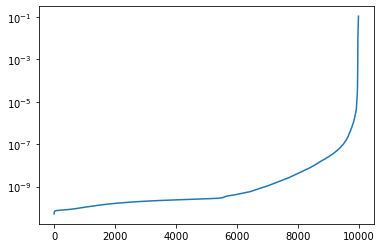

KL(best || ensemble) = 0.2822406589984894
OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=0, num_samples=10000, accuracy=0.7567368149757385, crossentropy=0.7721050381660461, kl_best_marginal=0.2822406589984894)


[OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=0, num_samples=10000, accuracy=0.7567368149757385, crossentropy=0.7721050381660461, kl_best_marginal=0.2822406589984894)]

In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=600,
    num_samples_list=[10000],
    num_trials=1,
    real_training_set_size=25,
    start_index=100,
    end_index_start=600,
    end_index_end=600,
)

In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=600,
    num_samples_list=[100],
    num_trials=5,
    real_training_set_size=25,
    start_index=100,
    end_index_start=600,
    end_index_end=600,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 500/100/0


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.6804956197738647
KL(best || ensemble) = 0.19274888932704926
OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=0, num_samples=100, accuracy=0.7375789284706116, crossentropy=0.8508146405220032, kl_best_marginal=0.19274888932704926)
Online Training Size/Num Samples/Trial: 500/100/1


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.6542937159538269
KL(best || ensemble) = 0.13428233563899994
OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=1, num_samples=100, accuracy=0.7475789189338684, crossentropy=0.8251611590385437, kl_best_marginal=0.13428233563899994)
Online Training Size/Num Samples/Trial: 500/100/2


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.6441978812217712
KL(best || ensemble) = 0.2969638705253601
OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=2, num_samples=100, accuracy=0.7358947396278381, crossentropy=0.8455144166946411, kl_best_marginal=0.2969638705253601)
Online Training Size/Num Samples/Trial: 500/100/3


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.6785297989845276
KL(best || ensemble) = 0.18460027873516083
OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=3, num_samples=100, accuracy=0.7406315803527832, crossentropy=0.8510602116584778, kl_best_marginal=0.18460027873516083)
Online Training Size/Num Samples/Trial: 500/100/4


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.6605399250984192
KL(best || ensemble) = 0.20700757205486298
OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=4, num_samples=100, accuracy=0.7357894778251648, crossentropy=0.8385571837425232, kl_best_marginal=0.20700757205486298)


[OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=0, num_samples=100, accuracy=0.7375789284706116, crossentropy=0.8508146405220032, kl_best_marginal=0.19274888932704926),
 OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=1, num_samples=100, accuracy=0.7475789189338684, crossentropy=0.8251611590385437, kl_best_marginal=0.13428233563899994),
 OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=2, num_samples=100, accuracy=0.7358947396278381, crossentropy=0.8455144166946411, kl_best_marginal=0.2969638705253601),
 OBIPerformance(total_training_set_size=525, real_training_set_size=25, online_training_set_size=500, trial_index=3, num_samples=100, accuracy=0.7406315803527832, crossentropy=0.8510602116584778, kl_best_marginal=0.18460027873516083),
 OBIPerformance(total_training_set_size=525, real_training_se

### 2000 Samples

In [ ]:
obi_results = online_bayesian_inference.eval_obi_simple(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=2100,
    start_index=25,
    end_index_start=25,
    end_index_end=25,
    num_samples_list=(10000,),
    num_trials=1,
    real_training_set_size=25,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10000/0
KL(best || ensemble) = 0.2191648930311203
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=0, trial_index=0, num_samples=10000, accuracy=0.7201250195503235, crossentropy=0.8908941745758057, kl_best_marginal=0.2191648930311203)


In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=2100,
    num_samples_list=[10000],
    num_trials=1,
    real_training_set_size=25,
    start_index=100,
    end_index_start=2100,
    end_index_end=2100,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 2000/10000/0


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 2000/100/0


  0%|          | 0/200 [00:00<?, ?it/s]

Restored best weights with objective 0.8056375980377197
tensor([-3365.6882, -2976.4114, -2826.6089, -3548.6770, -4287.3462, -5075.2031,
        -3848.6606, -2751.6106, -4008.7771, -4548.7617, -3979.0647, -3389.1299,
        -4684.8179, -2776.6997, -3759.4185, -2894.6919, -3655.4539, -2845.2976,
        -3946.4629, -5515.9019, -3292.9382, -3803.0945, -4000.2971, -3795.0356,
        -3122.1868, -3367.3479, -2999.9878, -4192.2026, -4070.6387, -3967.2039,
        -4144.4629, -4022.3542, -4255.4785, -3300.2732, -2139.8401, -3024.7319,
        -4375.7861, -3471.5857, -3713.9653, -3270.7954, -2472.4478, -5332.8687,
        -4765.7344, -3672.3184, -4261.6118, -3721.0803, -3195.6187, -3208.1150,
        -3618.5859, -3892.1763, -3448.3315, -3694.4785, -3866.9443, -2453.9417,
        -3671.8450, -4669.5649, -3914.1699, -3821.6543, -3263.3672, -2892.6643,
        -3988.8823, -5473.8125, -4169.4897, -4105.4854, -4923.8271, -3436.0288,
        -3171.5911, -4616.4253, -4278.5732, -3484.2515, -4297.00

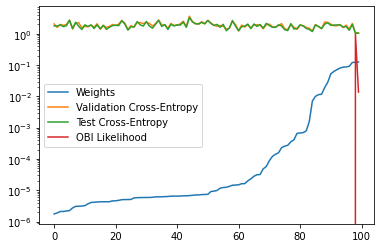

KL(best || ensemble) = 0.2806009352207184
OBIPerformance(total_training_set_size=2025, real_training_set_size=25, online_training_set_size=2000, trial_index=0, num_samples=100, accuracy=0.753000020980835, crossentropy=0.7955043315887451, kl_best_marginal=0.2806009352207184)


[OBIPerformance(total_training_set_size=2025, real_training_set_size=25, online_training_set_size=2000, trial_index=0, num_samples=100, accuracy=0.753000020980835, crossentropy=0.7955043315887451, kl_best_marginal=0.2806009352207184)]

In [ ]:
online_bayesian_inference.eval_validation_convex_optimization(
    log_probs_N_M_C=log_probs_N_M_C,
    labels_N=labels_N,
    training_set_size=2100,
    num_samples_list=[100],
    num_trials=1,
    real_training_set_size=25,
    start_index=100,
    end_index_start=2100,
    end_index_end=2100,
)